Deep coadds of all of the COS data to see if we can find a continumm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Test one- deep coadds of the x1ds (with RV shift?). If that looks bad, try the x2ds.

In [2]:
def spectra_adder(f_array, e_array, rcs = True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    if rcs:
        rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
        error = (var * rcs)**0.5
    else:
        error = var**0.05
    return flux, error

In [6]:
path ='/media/david/5tb_storage1/muscles/all_cos/'
x1ds = glob.glob('{}*x1dsum.fits'.format(path))
flts = glob.glob('{}*flt*.fits'.format(path))
print(x1ds)
# print(flts)

['/media/david/5tb_storage1/muscles/all_cos/ldlm02010_x1dsum.fits', '/media/david/5tb_storage1/muscles/all_cos/ldlm05010_x1dsum.fits', '/media/david/5tb_storage1/muscles/all_cos/ldlm11010_x1dsum.fits', '/media/david/5tb_storage1/muscles/all_cos/ldlm14010_x1dsum.fits', '/media/david/5tb_storage1/muscles/all_cos/ldlm17010_x1dsum.fits', '/media/david/5tb_storage1/muscles/all_cos/ldlm20010_x1dsum.fits', '/media/david/5tb_storage1/muscles/all_cos/ldlm23010_x1dsum.fits', '/media/david/5tb_storage1/muscles/all_cos/ldlm26010_x1dsum.fits', '/media/david/5tb_storage1/muscles/all_cos/ldlm29010_x1dsum.fits', '/media/david/5tb_storage1/muscles/all_cos/ldlm33010_x1dsum.fits', '/media/david/5tb_storage1/muscles/all_cos/ldlm40010_x1dsum.fits', '/media/david/5tb_storage1/muscles/all_cos/ldlmz5010_x1dsum.fits']


In [33]:
w1a = np.arange(1058, 1442, 0.1)
fluxa =[]
errora =[]
fluxb =[]
errorb = []
for x in x1ds:
    data = fits.getdata(x, 1)
    wa = data[1]['WAVELENGTH']
    fluxa.append(data[1]['FLUX'])
    errora.append(data[1]['ERROR'])
    wb = data[0]['WAVELENGTH']
    fluxb.append(data[0]['FLUX'])
    errorb.append(data[0]['ERROR'])
fa, ea = spectra_adder(np.array(fluxa), np.array(errora), rcs = True)
fb, eb = spectra_adder(np.array(fluxb), np.array(errorb), rcs = True)



/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in true_divide
  
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in true_divide
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


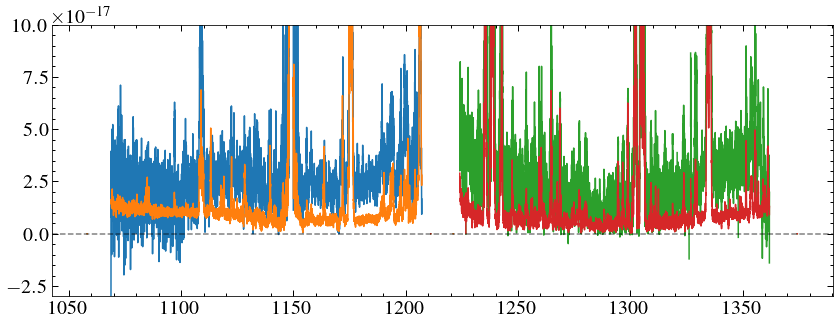

In [34]:


smooth = 5
for w, f, e in zip([wa, wb],[fa, fb],[ea, eb]):
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    plt.plot(w, f)
    plt.plot(w, e)
plt.ylim(-0.3e-16, 1e-16)
# plt.xlim(1100, 1150)
plt.axhline(0, ls='--', c='k', alpha=0.5)

Wow. Fit prominent lines?

In [35]:
for x in x1ds:
    hdr = fits.getheader(x, 0)
    print(hdr['TARGNAME'])
    print(hdr['CENWAVE'])
    data = fits.getdata(x, 1)
    wa, fa, ea = data[1]['WAVELENGTH'], data[1]['FLUX'], data[1]['ERROR']
    wb, fb, eb = data[0]['WAVELENGTH'], data[0]['FLUX'], data[0]['ERROR']
    fa = convolve(fa,Box1DKernel(smooth))
    ea = convolve(ea,Box1DKernel(smooth))/(smooth**0.5)
    fb = convolve(fb,Box1DKernel(smooth))
    eb = convolve(eb,Box1DKernel(smooth))/(smooth**0.5)
#     plt.subplot(131)
#     plt.plot(wa, fa)
#     plt.plot(wa, ea)
#     plt.xlim(1200, 1210)
#     plt.subplot(132)
#     plt.plot(wb, fb)
#     plt.plot(wb, eb)
#     plt.xlim(1230, 1240)
#     plt.subplot(133)
#     plt.plot(wb, fb)
#     plt.plot(wb, eb)
#     plt.xlim(1330, 1340)
#     plt.plot(wa, fa)
#     plt.plot(wb, fb)
#     plt.show()
#     print(wa[0], wa[-1])
#     print(wb[0], wb[-1])

    


GJ1132
1291
GJ676A
1222
GJ649
1222
GJ163
1291
GJ849
1291
GJ674
1222
GJ699
1222
L-980-5
1291
LP-756-18
1291
LHS-2686
1222
2MASS-J23062928-0502285
1291
GJ676A
1222


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


(-1e-16, 5e-16)

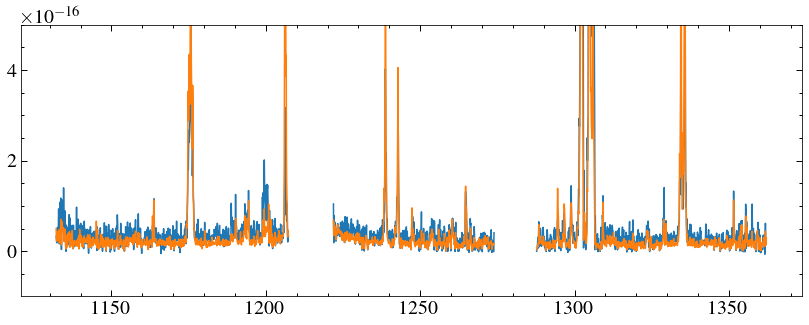

In [43]:
w1a = np.arange(1058, 1442, 0.1)
fluxes = []
errors = []

for x in x1ds:
    data = fits.getdata(x, 1)
    wc = np.array([], dtype=float)
    fc = np.array([], dtype=float)
    ec = np.array([], dtype=float)
    for dt in data[::-1]:
        wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
       # mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
        mask = (dq==0)
        wi, fi, ei = wi[mask], fi[mask], ei[mask]
        wc = np.concatenate((wc, wi))
        fc = np.concatenate((fc, fi))
        ec = np.concatenate((ec, ei))
     
    fc = interp1d(wc, fc, bounds_error=False, fill_value=0)(w1a)
    ec = interp1d(wc, ec, bounds_error=False, fill_value=0)(w1a)
    fluxes.append(fc)
    errors.append(ec)
flux, error = spectra_adder(np.array(fluxes), np.array(errors), rcs = True)
plt.plot(w1a, flux)
plt.plot(w1a, error)
plt.ylim(-0.1e-15, 0.5e-15)

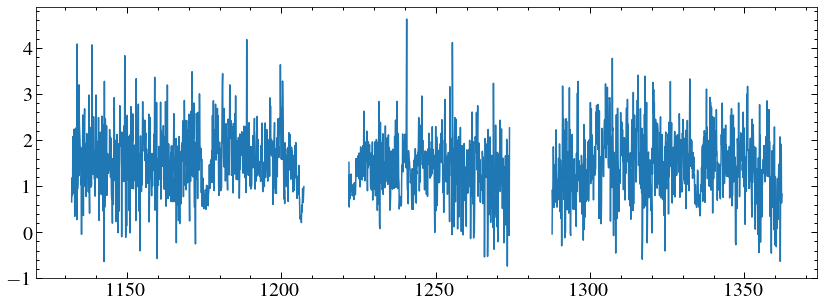

In [44]:
plt.plot(w1a, flux/error)

Need to distance scale them first?

In [46]:
params = Table.read('../optical/stellar_parameters.csv')

In [58]:
params

Target,RAJ2000,DEJ2000,Jmag,J_e,Hmag,H_e,Kmag,K_e,Rmag,R_e,spt,L_bol,L_bol_e,Mass,Mass_e,Radius,Radius_e,Teff,Teff_e,parallax,distance,P_rot_d
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64
GJ 1132,153.716027,-47.156796,9.245,0.026,8.666,0.031,8.322,0.027,13.098,0.11,M3.5,1.67e+31,5e+29,0.194,0.005,0.215,0.009,3196,72,83.07,12.03804021,126.59
GJ 676A,262.546646,-51.637012,6.711,0.02,6.082,0.024,5.825,0.029,8.675,0.012,M0,3.404e+32,8.3e+30,0.631,0.017,0.62,0.03,4014,94,63.07,15.85539876,41.2
GJ 15A,4.594036,44.022842,5.252,0.264,4.476,0.2,4.018,0.02,7.9,0.012,M1,8.61e+31,7e+29,0.393,0.009,0.385,0.002,3601,12,280.74,3.562014676,-1.0
GJ 649,254.536873,25.74423,6.448,0.021,5.865,0.02,5.624,0.016,8.685,0.012,M1,1.674e+32,1.7e+30,0.524,0.012,0.531,0.012,3621,41,96.38,10.3755966,-1.0
GJ 163,62.315307,-53.373737,7.948,0.026,7.428,0.04,7.135,0.021,10.734,0.012,M3.5,8.28e+31,2.4e+30,0.405,0.01,0.409,0.017,3460,76,66.59,15.01726986,61.0
GJ 849,332.417906,-4.640765,6.51,0.024,5.899,0.044,5.594,0.017,9.279,0.012,M3.5,1.105e+32,1e+30,0.465,0.011,0.464,0.018,3492,70,113.25,8.830022075,39.2
GJ 674,262.166316,-46.89513,5.711,0.019,5.154,0.033,4.855,0.018,8.337,0.012,M2.5,6.03e+31,1.4e+30,0.353,0.008,0.361,0.012,3404,59,220.24,4.540501271,32.9
GJ 699,269.452044,4.694597,5.244,0.02,4.834,0.034,4.524,0.02,8.298,0.012,M4,1.3e+31,2e+29,0.161,0.004,0.187,0.001,3223,17,548.31,1.823785815,130.4
L 980-5,215.313034,-1.122204,8.948,0.03,8.391,0.031,8.093,0.026,13.02,0.15,M3.5,2.49e+31,8e+29,0.232,0.006,0.25,0.01,3278,74,74.66,13.39405304,92.23


In [51]:
hdul[0].header['TARGNAME']

'GJ1132'

In [57]:
for x in x1ds:
    hdr = fits.getheader(x, 0)
    print(hdr['TARGNAME'])

GJ1132
GJ676A
GJ649
GJ163
GJ849
GJ674
GJ699
L-980-5
LP-756-18
LHS-2686
2MASS-J23062928-0502285
GJ676A
